<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/7_TrainingWorkflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

### **Processing multiple epochs**

In [ ]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

32768/30874 [===============================] - 0s 0us/step


In [ ]:
def plot_batch_sizes(ds):
  batch_size = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_size)), batch_size)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

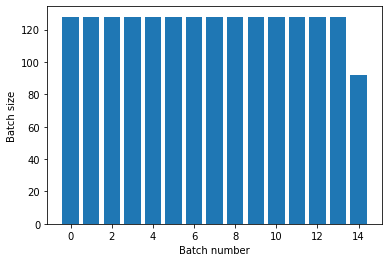

In [ ]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

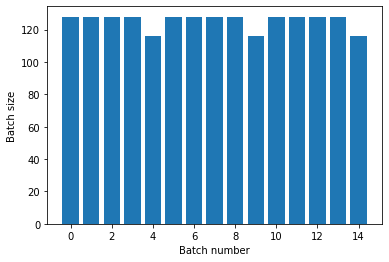

In [ ]:
#If you need clear epoch separation, put Dataset.batch before the repeat

titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(titanic_batches)

In [ ]:
#If you would like to perform a custom computation (e.g to collect statistics) at the end of epoch then it's simplest 
# to restart the dataset iteration on each epoch:

epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch:", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch: 0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch: 1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch: 2


Randomly Shuffling input data

In [ ]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter,lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

In [ ]:
#Since the buffer_size is 100,and the atch size is 20,the first batch contains no elements with an index over 120.

n,line_batch = next(iter(dataset))
print(n.numpy())

[ 73  69  79  77  39 101  33  81  34   7  98  42  41 111   9  22  84   4
  23   8]


In [ ]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[594 397 279 612 359 624 600 414 603 395]
[569 606 599 613 591 595 608 585 627 579]
[604 622 506 449 560 495 372 567]
[85 59 16 89  2 39 13 48 82 66]
[ 91  10  51  29  35  98 110   8  21  38]


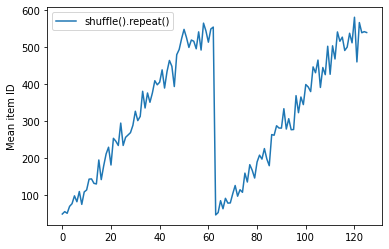

In [ ]:
shuffle_repeat = [n.numpy().mean() for n,line_batch in shuffled]
plt.plot(shuffle_repeat, label = "shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [ ]:
#But a repeat before a shuffle mixes the epoch boundaries together:

dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size = 100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[496 517  14 564 526 573   6 501 598 426]
[  2 466  17 624 561 549 595   0 506   3]
[616 268  13 553  28 544 399  11 563 464]
[613  10 581 627 558 593 575 623 610 618]
[ 43 574 612  33 461  63 384 599  49   1]
[475  19  27  36 422  73 554  67  61 617]
[586 582 490  70  40  77 559  45  41  52]
[ 91  18  50  66  89  56  21 590  82 608]
[ 57 626 611 607  64  88  30  78 309 110]
[ 95  97 578  94 439  31  58  99 560  87]
[  8 592  44  90 112  85 605  76 111  69]
[119 120  62  47  72  22  93 620  23 401]
[107 138  16  26 115  74 585  79  84  29]
[118 600  65 116  55  20 271   7 124 579]
[603  32 128  51  92 165 527 622 467  80]


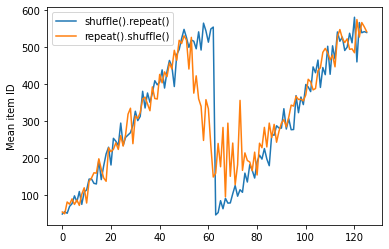

In [ ]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label = "shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

### **Preprocessing data**

Decoding image data and resizing it


In [ ]:
#When training a neural network on real-world image data, it is often necessary 
#to convert images of different sizes to a common size,so that they may be
#batched into a fixed size.

#Rebulding the flower filenames dataset:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)
 
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [ ]:
# Read an image a file, decodes it into a dense tensor, and resizes it 
# to a fixe shape. 

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

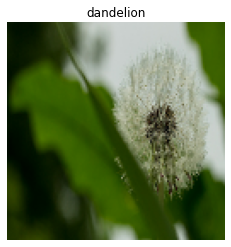

In [ ]:
#Test that it work.

file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')
show(image, label)


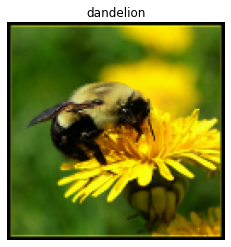

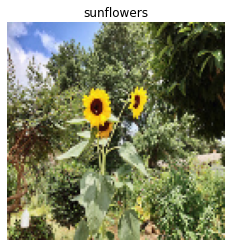

In [ ]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

Applying arbitrary Python logic

In [ ]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


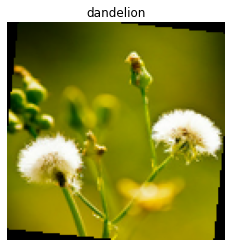

In [ ]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [ ]:
#To use this function with Dataset.map the same caveats apply as with 
#dataset.from_generator, you need to describe the return shapes
#and types when you apply the function:

def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


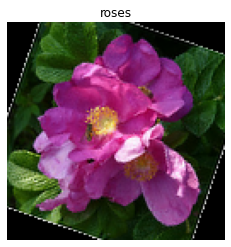

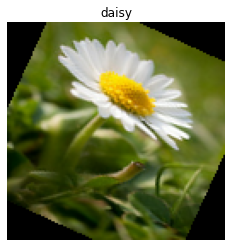

In [ ]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

Parsing tf.Example protocol buffer messages


In [ ]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames=[fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

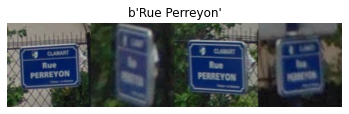

In [ ]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [ ]:
raw_example = next(iter(dataset))

def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded' : tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text' : tf.io.FixedLenFeature(shape=(), dtype = tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [ ]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [ ]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [ ]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

Time series windowing

In [ ]:
range_ds = tf.data.Dataset.range(100000)

In [ ]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


In [ ]:
def dense_1_step(batch):
  #shift features and labels one step relaative to each other
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), "=>", label.numpy())

[0 1 2 3 4 5 6 7 8] => [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18] => [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28] => [21 22 23 24 25 26 27 28 29]


In [ ]:
#To predict a whole window instead of a fixed offset you can split the batchs nto two parts:

batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],  #take the 5 step
          batch[-5:])  #take the remainder

predict_5_step = batches.map(label_next_5_steps)

for features, label in predict_5_step.take(3):
  print(features.numpy(), "=>",label.numpy())

[0 1 2 3 4 5 6 7 8 9] => [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24] => [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39] => [40 41 42 43 44]


In [ ]:
#To allow some overlap between the feature of one batch and the labels of another, us Dataset.zip:

feature_length = 10
label_length = 5

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:-5])

predict_5_steps = tf.data.Dataset.zip((features, labels))

for features, label in predict_5_step.take(3):
  print(features.numpy(),"=>", label.numpy())

[0 1 2 3 4 5 6 7 8 9] => [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24] => [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39] => [40 41 42 43 44]


In [ ]:
#Using window

window_size = 5
windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds) 

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


In [ ]:
for x in windows.flat_map(lambda x:x).take(30):
  print(x.numpy(), end='')

Cause: could not parse the source code:

for x in windows.flat_map(lambda x:x).take(30):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

for x in windows.flat_map(lambda x:x).take(30):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
012341234523456345674567856789

In [ ]:
#In nearly all cases, you will to .batch the dataset first:

def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


In [ ]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [ ]:
ds = make_window_dataset(range_ds, window_size=10, shift =5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


In [ ]:
#Then it's easy to extract labels, as before:

dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(),"=>",labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


Resampling

In [ ]:
#When working with a dataset that is very class-imbalanced, you may want to 
#resample the dataset. tf.data provides two methods to do this.
#This credit card fraud dataset is a good example of this sort of problem.

zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip','.csv')

69156864/69155632 [==============================] - 1s 0us/step


In [ ]:
creditscard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024,label_name="Class",
    #set the column types : 30 float and an int.
    column_defaults=[float()]*30+[int()]
)

In [ ]:
#Now, check the distribution of classes, itis highly skewed:

def count(counts, batch):
  features, labels = batch
  class_1 = labels==1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels==0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [ ]:
counts = creditscard_ds.take(10).reduce(
    initial_state={'class_0':0, 'class_1':0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9954 0.0046]


In [ ]:
#Datasets sampling
#Here, just use filter to generate them from the credit card fraud data:

negative_ds = (
    creditscard_ds
     .unbatch()
     .filter(lambda features, label: label==0)
     .repeat())
positive_ds = (
    creditscard_ds
     .unbatch()
     .filter(lambda features, label: label==1)
     .repeat())


Cause: could not parse the source code:

     .filter(lambda features, label: label==0)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

     .filter(lambda features, label: label==0)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

     .filter(lambda features, label: label==1)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

     .filter(lambda features, label: label==1)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @t

In [ ]:
for feature, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


In [ ]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds],[0.5,0.5]).batch(10)

In [ ]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 1 0 0 1 0 0 1 0]
[0 0 0 1 1 0 1 0 0 0]
[1 1 1 1 1 0 1 0 0 0]
[0 1 0 0 0 1 1 1 1 1]
[0 0 1 1 1 0 0 1 1 1]
[0 0 0 0 0 1 0 0 1 0]
[0 1 0 1 1 0 1 0 1 1]
[1 0 1 1 1 1 1 0 1 0]
[0 0 0 0 0 1 1 1 1 0]
[1 0 1 0 0 0 0 0 1 1]


Rejection resampling

In [ ]:
def class_func(features, label):
  return label

In [ ]:
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions
)

In [ ]:
resampler_ds = creditscard_ds.unbatch().apply(resampler).batch(10)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [ ]:
balanced_ds = resampler_ds.map(lambda extra_label, features_and_label: features_and_label)

In [ ]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 1 0 1 0 1 1 0 0 0]
[0 1 1 1 1 1 1 0 1 0]
[0 0 1 1 0 0 1 0 0 1]
[0 1 0 0 0 1 1 0 0 1]
[1 1 1 0 0 0 0 0 1 1]
[1 1 0 1 1 1 1 0 1 1]
[1 1 0 0 1 0 0 0 1 1]
[1 0 1 0 1 1 0 0 1 1]
[0 0 1 0 1 1 0 1 0 1]
[1 0 0 1 1 1 1 1 1 1]


### **Iterator Checkpoint**


Tensorflow support taking checkpoints so that when your training process restarts it can restore the latest checkpoint to recover most of its progress. In addition to checkpointing the model variables, you can also checkpoint the progress of the dataset iterator. This could be useful if you have a large dataset and don't want to start the dataset from the beginning on each restart. Note however that iterator checkpoints may be large, since transformations such as shuffle and prefetch reqiure buffering elements within the iterator.

To include your iterator in a chechpoint, pass the iterator to the tf.train.Checkpoint constructor 

In [ ]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


### **Using tf.data with tf.keras**

The tf.keras API simplifies many aspects of creating and executing machine learnig models. its .fit() and .evaluate() and .predict() APIs support datasets as inputs. Here is a qiuck dataset and model setup:

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Passing a dataset of (feature, label) pairs is all that's needed for Model.fit and Model.evaluate:

In [ ]:
model.fit(fmnist_train_ds, epochs =2)

Epoch 1/2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1875/1875 [==============================] - 3s 1ms/step - loss: 0.5971 - accuracy: 0.7999
Epoch 2/2
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4615 - accuracy: 0.8424


In [ ]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8687
Epoch 2/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8516


In [ ]:
#For evaluation you can pass the number of evaluation steps:

loss, accuracy = model.evaluate(fmnist_train_ds)
print("loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.4412 - accuracy: 0.8495
loss : 0.44120022654533386
Accuracy : 0.8495166897773743


In [ ]:
#For long datasets, set the number of steps to evaluate:

loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps = 10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.3014 - accuracy: 0.9094
Loss : 0.3014334440231323
Accuracy : 0.909375011920929


In [ ]:
#The labels are not required in when calling Model.predict.

predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps=10)
print(result.shape)

(320, 10)


In [ ]:
#But the labels are ignored if you do pass a dataset containing them:
result = model.predict(fmnist_train_ds,steps=10)
print(result.shape)


(320, 10)


In [ ]:
#But the labels are ignored if you do pass a dataset containing them:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)


## **tf.estimator**
To use a Dataset in the input_fn of a tf.estimator. Estimator, simply returns the Dataset from the input_fn and the frame work will take care of consuming its element for you. 
for example

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
def train_input_fn():
  titanic = tf.data.experimental.make_csv_dataset(
      titanic_file, batch_size = 32, 
      label_name = "survived")
  titanic_batches = (
      titanic.cache().repeat().shuffle(500)
      .prefetch(tf.data.experimental.AUTOTUNE))
  return titanic_batches

In [ ]:
embark = tf.feature_column.categorical_column_with_hash_bucket('embark_town',32)
cls = tf.feature_column.categorical_column_with_vocabulary_list('class', ['First', 'Second','Third'])
age = tf.feature_column.numeric_column('age')

In [ ]:
import tempfile
model_dir = tempfile.mkdtemp()
model = tf.estimator.LinearClassifier(
    model_dir = model_dir,
    feature_columns=[embark, cls , age],
    n_classes = 2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp74h3rflo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
model = model.train(input_fn=train_input_fn,steps = 100)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp74h3rflo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100...
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmp74h3rflo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100...
INFO:tensorflow:Loss for final step: 0.5744685.


In [ ]:
result = model.evaluate(train_input_fn, steps  = 10)

for key, value in result.items():
  print(key, ":", value)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-11T04:56:05Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp74h3rflo/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Inference Time : 0.76918s
INFO:tensorflow:Finished evaluation at 2021-01-11-04:56:06
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.659375, accuracy_baseline = 0.6125, auc = 0.7472638, auc_precision_recall = 0.6424507, average_loss = 0.6121102, global_step = 100, label/mean = 0.3875, loss = 0.6121102, precision = 0.7777778, predictio

In [ ]:
for pred in model.predict(train_input_fn):
  for key, value in pred.items():
    print(key, ":", value)
  break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp74h3rflo/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
logits : [-2.7784]
logistic : [0.0585]
probabilities : [0.9415 0.0585]
class_ids : [0]
classes : [b'0']
all_class_ids : [0 1]
all_classes : [b'0' b'1']
